# Evolving FIFA Ultimate Team Squards with Genetic Algorithms

Ever since the early 2010s, FIFA Ultimate Team (FUT) has been an integral part of the popular FIFA Football video games series (FIFA) by EA Sports. In FUT you can create your own squad of players from a pool of more than 10,000 cards, play against your friends and win online tournaments. Starting with a mediocre team, the goal is to collect prizes and trade players, so that you can eventually build the squad of your dreams. I personally played FUT excessively on FIFA 2012 and FIFA 2013 during my high school years but eventually got tired of the ever increasing emphasis on micro transactions and quit. Still, over the last years FUT has gained millions of avid fans, where large quantities of real-world currency are spent on cards.

Essentially, FUT squads are evaluated by three major criteria: rating (sum of the individual players' points), chemistry (an indicator of how well the players can collaborate, further explained in Chemistry) and price (sum of the individual players' cost). Consering the large number of unqiue cards, finding the optimal composition of players is not a trivial task.

![An example FUT squad with rating, chemistry and price.](https://raw.githubusercontent.com/jbj2505/fut-squad-evolver/master/images/fut1.png)

The goal of this project is to use Genetic Algorithms (GA) to evolve team with high rating, high chemistry and low cost.

## Setup

We will use the common Python libraries for table operations, cacluations and visualisation. Also we will set the random number generator seed for reproducability.

In [53]:
import warnings
import pickle
from timeit import default_timer as now
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap

In [54]:
cmap = get_cmap("viridis")

In [52]:
# Matplotlib default changes.
mpl.rcParams["figure.facecolor"] = "black"
mpl.rcParams["figure.figsize"] = (12, 10)
mpl.rcParams["axes.facecolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "white"
mpl.rcParams["axes.labelcolor"] = "white"
mpl.rcParams["font.size"] = 14
mpl.rcParams["grid.color"] = "white"
mpl.rcParams["savefig.facecolor"] = "black"
mpl.rcParams["text.color"] = "white"
mpl.rcParams["xtick.color"] = "white"
mpl.rcParams["ytick.color"] = "white"
mpl.rcParams["hatch.color"] = "white"
mpl.rcParams["lines.color"] = "white"
mpl.rcParams["legend.edgecolor"] = "none"
mpl.rc('animation', html='html5')

In [2]:
np.random.seed(42)

## Creating the Game Engine

In order to build well-performing teams, we will first need to represent the game engine and calculate the rating, chemistry and fitness for squads.

### Creating Positions

First, we define all possible positions in a formation the game knows about.

In [3]:
_POSITIONS = ["GK", 
              "RB", "CB", "LB", "LWB", "RWB",
              "CDM", "CM", "CAM", "RM", "LM",
              "RW", "LW", "CF", "RF", "LF", "ST"
             ]

Next, we calculate the chemistry between two positions (the player's preferred position and the actual position in the formation), indicated by the following table:

![Chemistry Table](https://www.fifauteam.com/wp-content/uploads/2013/10/A215-7E.jpg)

In [4]:
_POSITION_CHEMISTRY = {
    ("CB", "RB"): 1,
    ("LB", "RB"): 1,
    ("LB", "CB"): 1,
    ("RWB", "RB"): 2,
    ("LWB", "LB"): 2,
    ("LWB", "RWB"): 1,
    ("CDM", "CB"): 1,
    ("CM", "CDM"): 2,
    ("CAM", "CDM"): 1,
    ("CAM", "CM"): 2,
    ("RM", "RB"): 1,
    ("RM", "RWB"): 1,
    ("RM", "CM"): 1,
    ("LM", "LB"): 1,
    ("LM", "LWB"): 1,
    ("LM", "CM"): 1,
    ("LM", "RM"): 1,
    ("RW", "RB"): 1,
    ("RW", "RWB"): 1,
    ("RW", "RM"): 2,
    ("LW", "LB"): 1,
    ("LW", "LWB"): 1,
    ("LW", "LM"): 2,
    ("LW", "RW"): 1,
    ("CF", "CAM"): 2,
    ("RF", "RM"): 1,
    ("RF", "RW"): 2,
    ("RF", "CF"): 1,
    ("LF", "LM"): 1,
    ("LF", "LW"): 2,
    ("LF", "CF"): 1,
    ("LF", "RF"): 1,
    ("ST", "CF"): 2,
    ("CF", "RF"): 1,
    ("CF", "LF"): 1    
}

In [5]:
def _get_position_chemistry(position_1, position_2):
    if position_1 not in _POSITIONS or position_2 not in _POSITIONS:
        raise IndexError
    if position_1 == position_2:
        return 3
    if (position_1, position_2) in _POSITION_CHEMISTRY.keys():
        return _POSITION_CHEMISTRY[(position_1, position_2)]
    if (position_2, position_1) in _POSITION_CHEMISTRY.keys():
        return _POSITION_CHEMISTRY[(position_2, position_1)]
    return 0

In [6]:
_get_position_chemistry("LB", "LB")

3

In [7]:
class Position:
    
    def __init__(self, id):
        self.id = id
        
    def get_chemistry(self, other):
        return _get_position_chemistry(self.id, other.id)
    
    def get_compatible_positions(self, min_chemistry=2):
        compatible_positions = []
        for position in POSITIONS.values():
            if self.get_chemistry(position) >= min_chemistry:
                compatible_positions.append(position)
        return compatible_positions
    
    def __repr__(self):
        return "{}(id={})".format(self.__class__.__name__, self.id)

In [8]:
POSITIONS = {p: Position(p) for p in _POSITIONS}
POSITIONS

{'GK': Position(id=GK),
 'RB': Position(id=RB),
 'CB': Position(id=CB),
 'LB': Position(id=LB),
 'LWB': Position(id=LWB),
 'RWB': Position(id=RWB),
 'CDM': Position(id=CDM),
 'CM': Position(id=CM),
 'CAM': Position(id=CAM),
 'RM': Position(id=RM),
 'LM': Position(id=LM),
 'RW': Position(id=RW),
 'LW': Position(id=LW),
 'CF': Position(id=CF),
 'RF': Position(id=RF),
 'LF': Position(id=LF),
 'ST': Position(id=ST)}

In [9]:
def get_positions():
    return POSITIONS    
    
def get_position(position):
    return POSITIONS[position]

In [10]:
get_position("CM").get_compatible_positions(3)

[Position(id=CM)]

### Creating Players

![](https://raw.githubusercontent.com/jbj2505/fut-squad-evolver/master/images/fut3.png)

First, we load our data into the session.

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    players = pd.read_csv("../input/FIFA19 - Ultimate Team players.csv")
players.head()

,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,rf,lf,rw,lw,st,price_ps4,price_xbox,price_pc,traits,specialties
0,1,Pelé,Arantes Nascimento Edson,Gold - Rare,Icon,NaN,98,Icons,Icons,Brazil,...,96.0,96,96,96,95,NaN,NaN,NaN,Finesse Shot,"Speedster, Aerial Threat, Dribbler, Play Maker..."
1,2,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,97,Icons,Icons,Argentina,...,94.0,94,94,94,90,2400000.0,2954000.0,NaN,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Speedster, Dribbler, Play Maker, Distance Shoo..."
2,3,Ronaldo,Nazário de Lima Ronaldo Luís,Gold - Rare,Icon,NaN,96,Icons,Icons,Brazil,...,94.0,94,92,92,94,5697000.0,7650000.0,NaN,"Tries To Beat Defensive Line, Finesse Shot","Speedster, Dribbler, Distance Shooter, FK Spec..."
3,4,Pelé,Arantes Nascimento Edson,Gold - Rare,Icon,NaN,95,Icons,Icons,Brazil,...,94.0,94,94,94,92,2600000.0,3650000.0,4501000.0,Finesse Shot,"Speedster, Dribbler, Distance Shooter, Crosser..."
4,5,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,95,Icons,Icons,Argentina,...,92.0,92,92,92,88,1695000.0,2600000.0,4201000.0,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Dribbler, Play Maker, Distance Shooter, Crosse..."


We remove players that do not have a price stated.

In [12]:
condition = ~players.price_ps4.isna()
players = players[condition].reset_index()
players.head()

,index,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,...,rf,lf,rw,lw,st,price_ps4,price_xbox,price_pc,traits,specialties
0,1,2,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,97,Icons,Icons,...,94.0,94,94,94,90,2400000.0,2954000.0,NaN,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Speedster, Dribbler, Play Maker, Distance Shoo..."
1,2,3,Ronaldo,Nazário de Lima Ronaldo Luís,Gold - Rare,Icon,NaN,96,Icons,Icons,...,94.0,94,92,92,94,5697000.0,7650000.0,NaN,"Tries To Beat Defensive Line, Finesse Shot","Speedster, Dribbler, Distance Shooter, FK Spec..."
2,3,4,Pelé,Arantes Nascimento Edson,Gold - Rare,Icon,NaN,95,Icons,Icons,...,94.0,94,94,94,92,2600000.0,3650000.0,4501000.0,Finesse Shot,"Speedster, Dribbler, Distance Shooter, Crosser..."
3,4,5,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,95,Icons,Icons,...,92.0,92,92,92,88,1695000.0,2600000.0,4201000.0,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Dribbler, Play Maker, Distance Shooter, Crosse..."
4,5,6,Maldini,Paolo Maldini,Gold - Rare,Icon,NaN,94,Icons,Icons,...,68.0,68,69,69,70,1526000.0,NaN,NaN,Team Player,"Aerial Threat, Tackler, Tactician, Complete De..."


We convert all column names to lower case.

In [13]:
players.columns = players.columns.str.lower()
players.head()

,index,player_id,player_name,player_extended_name,quality,revision,origin,overall,club,league,...,rf,lf,rw,lw,st,price_ps4,price_xbox,price_pc,traits,specialties
0,1,2,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,97,Icons,Icons,...,94.0,94,94,94,90,2400000.0,2954000.0,NaN,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Speedster, Dribbler, Play Maker, Distance Shoo..."
1,2,3,Ronaldo,Nazário de Lima Ronaldo Luís,Gold - Rare,Icon,NaN,96,Icons,Icons,...,94.0,94,92,92,94,5697000.0,7650000.0,NaN,"Tries To Beat Defensive Line, Finesse Shot","Speedster, Dribbler, Distance Shooter, FK Spec..."
2,3,4,Pelé,Arantes Nascimento Edson,Gold - Rare,Icon,NaN,95,Icons,Icons,...,94.0,94,94,94,92,2600000.0,3650000.0,4501000.0,Finesse Shot,"Speedster, Dribbler, Distance Shooter, Crosser..."
3,4,5,Maradona,Diego Maradona,Gold - Rare,Icon,NaN,95,Icons,Icons,...,92.0,92,92,92,88,1695000.0,2600000.0,4201000.0,"Avoids Using Weaker Foot, Finesse Shot, Flair,...","Dribbler, Play Maker, Distance Shooter, Crosse..."
4,5,6,Maldini,Paolo Maldini,Gold - Rare,Icon,NaN,94,Icons,Icons,...,68.0,68,69,69,70,1526000.0,NaN,NaN,Team Player,"Aerial Threat, Tackler, Tactician, Complete De..."


In [14]:
players.shape

(15544, 85)

At this point we have 15,544 players and 85 columns.

Next we define a Player class.

In [15]:
class Player:
    
    def __init__(self, data):
        """
        Creates Player instance.
        Args:
            data: a Pandas series from the players dataframe.
        Returns:
            a Player instance.
        """
        self.data = data
        self.position = get_position(self.data.position)
        
    def __eq__(self, other):
        """
        Checks for equality between self and other.
        One player can have several card versions, so only matching the player_id is not sufficient.
        Args:
            other: a Player instance.
        Returns:
            a boolean, indicating equality between self and other.
        """
        if self.data.player_extended_name != other.data.player_extended_name:
            return False
        if self.data.date_of_birth != other.data.date_of_birth:
            return False
        return True
    
    def get_chemistry(self, other):
        """
        Calculates chemistry to other.
        Args:
            other: a Player instance.
        Returns:
            an integer, representing the chemistry between self and other.
        """
        chemistry = 0
        if self.data.nationality == other.data.nationality:
            chemistry += 1
        if self.data.league == other.data.league:
            chemistry += 1
        if self.data.club == other.data.club:
            chemistry += 1
        return chemistry
    
    def __repr__(self):
        return "{}(id={}, name={}, overall={}, position={}, price={}, nationality={}, league={}, club={})".format(self.__class__.__name__, self.data.player_id, 
                                                                                                                  self.data.player_name, self.data.overall,
                                                                                                                  self.position.id, int(self.data.price_ps4),
                                                                                                                  self.data.nationality, self.data.league, self.data.club)

We convert the dataframe to a series of Player objects.

In [16]:
players = players.apply(lambda x: Player(x.copy()), axis=1)
players.head()

0    Player(id=2, name=Maradona, overall=97, positi...
1    Player(id=3, name=Ronaldo, overall=96, positio...
2    Player(id=4, name=Pelé, overall=95, position=C...
3    Player(id=5, name=Maradona, overall=95, positi...
4    Player(id=6, name=Maldini, overall=94, positio...
dtype: object

## Creating Formation

Conceptually, a formation is a set of 11 slots, where every slot has an assigned position and links to adjacent slots.

![](https://raw.githubusercontent.com/jbj2505/fut-squad-evolver/master/images/fut4.png)

First, we will create the Link class.

In [17]:
class Link:
    
    def __init__(self, slot_1, slot_2):
        """
        Creates Link instance.
        Args:
            slot_1: an instance of Slot.
            slot_2: an instance of Slot.
        Returns:
            an instance of Link.
        """
        self.slot_1 = slot_1
        self.slot_2 = slot_2
        slot_1.links.append(self)
        slot_2.links.append(self)
        
    def get_other(self, slot):
        """
        Get partner of slot.
        Args:
            slot: an instance of Slot.
        Returns:
            an instance of Slot.
        Raise:
            IndexError, when slot not slot_1 and slot not slot_2.
        """
        if slot is self.slot_1:
            return self.slot_2
        if slot is self.slot_2:
            return self.slot_1
        raise IndexError
        
    def __repr__(self):
        return "{}(slot_1={}, slot_2={})".format(self.__class__.__name__, self.slot_1.slot_id, self.slot_2.slot_id)

In [18]:
def make_links(links, slots):
    """Converts links dictionary to Link instances."""
    return [Link(slots[p1], slots[p2]) for p1, p2 in links]

Then we create the Slot class.

In [19]:
class Slot:
    
    def __init__(self, slot_id, position, player=None, links=None):
        """
        Creates Slot instance.
        Args:
            slot_id: string sequence.
            position: instance of Position.
            player: instance of Player.
            links: list of Link instances.
        Returns:
            instance of Slot.
        """
        self.slot_id = slot_id
        self.position = position
        self.player = player
        if links is None:
            links = []
        self.links = links
        
    def __repr__(self):
        return "{}(id={}, position={}, player={})".format(self.__class__.__name__, self.slot_id, self.position, self.player)
    
    def get_linked_slots(self):
        """Return all slots that this slot is linked to."""
        return [l.get_other(self) for l in self.links]
    
    def get_linked_players(self):
        """Return all players that this slot is linked to."""
        return [s.player for s in self.get_linked_slots()]
    
    def get_position_chemistry(self):
        """Get chemistry between natural position of player and position of slot."""        
        return self.position.get_chemistry(self.player.position)
    
    def get_link_chemistry(self):
        """Get chemistry between player in slot and players in linked slots."""
        return np.mean([self.player.get_chemistry(p) for p in self.get_linked_players()])
    
    def get_chemistry(self):
        """Get overall chemistry, given link chemistry and position chemistry."""
        return get_chemistry(self.get_link_chemistry(), self.get_position_chemistry())

We also need a function that calculates the overall chemistry of a slot, given the link and the position chemistry, according to this table:

![](https://www.fifauteam.com/wp-content/uploads/2014/01/A215-6E.jpg)

In [20]:
def get_chemistry(link_chemistry, position_chemistry):
    """
    Calculates individal slot chemistry, given link chemistry and position chemistry.
    Args:
        link_chemistry: float value.
        position_chemistry: int value.
    Returns:
        a float value.
    Raises:
        IndexError, when link_chemistry or position_chemistry not within boundaries.
    """
    if link_chemistry < 0.3:
        if position_chemistry == 0:
            return 0
        if position_chemistry == 1:
            return 1
        if position_chemistry == 2:
            return 2
        if position_chemistry == 3:
            return 3
        raise IndexError
    if link_chemistry < 1.:
        if position_chemistry == 0:
            return 1
        if position_chemistry == 1:
            return 3
        if position_chemistry == 2:
            return 5
        if position_chemistry == 3:
            return 6
        raise IndexError
    if link_chemistry <= 1.6:
        if position_chemistry == 0:
            return 2
        if position_chemistry == 1:
            return 5
        if position_chemistry == 2:
            return 8
        if position_chemistry == 3:
            return 9
        raise IndexError
    if link_chemistry > 1.6:
        if position_chemistry == 0:
            return 2
        if position_chemistry == 1:
            return 5
        if position_chemistry == 2:
            return 9
        if position_chemistry == 3:
            return 10
        raise IndexError
    raise IndexError

Finally, we can define a Formation class.

In [21]:
class Formation:
    
    def __init__(self, slots, links):
        """
        Creates instance of Formation.
        Args:
            slots: list of Slot instances.
            links: list of Link instances.
        Returns:
            instance of Formation.
        """
        self.slots = slots
        self.links = links
        
    def get_chemistry(self):
        """Calculates chemistry of formation. Makes sure it is less of equal to 100."""
        return np.min([np.sum([s.get_chemistry() for s in self.slots.values()]), 100])
    
    def get_rating(self):
        """Calculates rating of formation."""
        return np.sum([s.player.data.overall for s in self.slots.values()])
    
    def get_price(self):
        """Calculates price of formation."""
        return np.sum([s.player.data.price_ps4 for s in self.slots.values()])
        
    def __repr__(self):
        return "{}(slots={}, links={})".format(self.__class__.__name__, self.slots, self.links)

Let us create two formations: 433 and 5221.

In [22]:
formation_map = {}

In [23]:
# Creating 433 formation.

# Creating slots.
slots = {
    "GK": "GK",
    "LB": "LB",
    "CB1": "CB",
    "CB2": "CB",
    "RB": "RB",
    "CM1": "CM",
    "CM2": "CM",
    "CM3": "CM",
    "LW": "LW",
    "ST": "ST",
    "RW": "RW"
}

slots = {k: Slot(k, get_position(v)) for k, v in slots.items()}


# Creating links.
links = [("GK", "CB1"), ("GK", "CB2"),
         ("LB", "CB1"), ("CB1", "CB2"), ("CB2", "RB"), 
         ("LB", "CM1"), ("CB1", "CM2"), ("CB2", "CM2"), ("RB", "CM3"),
         ("CM1", "CM2"), ("CM2", "CM3"),
         ("CM1", "LW"), ("CM2", "ST"), ("CM3", "RW"),
         ("LW", "ST"), ("ST", "RW")
        ]

links = make_links(links, slots)


# Adding to formation map.
formation_map["433"] = Formation(slots, links)

In [24]:
# Creating 5221 formation.

# Creating slots.
slots = {
    "GK": "GK",
    "LWB": "LWB",
    "CB1": "CB",
    "CB2": "CB",
    "CB3": "CB",
    "RWB": "RWB",
    "CM1": "CM",
    "CM2": "CM",
    "LW": "LW",
    "ST": "ST",
    "RW": "RW"
}
slots = {k: Slot(k, get_position(v)) for k, v in slots.items()}


# Creating links.
links = [("GK", "CB1"), ("GK", "CB2"), ("GK", "CB3"),
         ("LWB", "CB1"), ("CB1", "CB2"), ("CB2", "CB3"), ("CB3", "RWB"),
         ("LWB", "LW"), ("LWB", "CM1"), ("CB2", "CM1"), ("CB2", "CM2"), ("RWB", "RW"),
         ("CM1", "CM2"),
         ("CM1", "LW"), ("CM1", "ST"), ("CM2", "ST"), ("CM2", "RW"),
         ("LW", "ST"), ("ST", "RW")
        ]

links = make_links(links, slots)


# Adding to formation map.
formation_map["5221"] = Formation(slots, links)

In [25]:
formation_map["5221"]

Formation(slots={'GK': Slot(id=GK, position=Position(id=GK), player=None), 'LWB': Slot(id=LWB, position=Position(id=LWB), player=None), 'CB1': Slot(id=CB1, position=Position(id=CB), player=None), 'CB2': Slot(id=CB2, position=Position(id=CB), player=None), 'CB3': Slot(id=CB3, position=Position(id=CB), player=None), 'RWB': Slot(id=RWB, position=Position(id=RWB), player=None), 'CM1': Slot(id=CM1, position=Position(id=CM), player=None), 'CM2': Slot(id=CM2, position=Position(id=CM), player=None), 'LW': Slot(id=LW, position=Position(id=LW), player=None), 'ST': Slot(id=ST, position=Position(id=ST), player=None), 'RW': Slot(id=RW, position=Position(id=RW), player=None)}, links=[Link(slot_1=GK, slot_2=CB1), Link(slot_1=GK, slot_2=CB2), Link(slot_1=GK, slot_2=CB3), Link(slot_1=LWB, slot_2=CB1), Link(slot_1=CB1, slot_2=CB2), Link(slot_1=CB2, slot_2=CB3), Link(slot_1=CB3, slot_2=RWB), Link(slot_1=LWB, slot_2=LW), Link(slot_1=LWB, slot_2=CM1), Link(slot_1=CB2, slot_2=CM1), Link(slot_1=CB2, slot_2=C

## Creating Genetic Algorithm

Finally, we have made it to the genetic optimisation.

First, we will create a compatible player dictionary that contains all players that have a chemistry of at least 2 to a given position.

In [26]:
COMPATIBLE_POSITIONS = {k: v.get_compatible_positions(2) for k, v in get_positions().items()}
COMPATIBLE_POSITIONS

{'GK': [Position(id=GK)],
 'RB': [Position(id=RB), Position(id=RWB)],
 'CB': [Position(id=CB)],
 'LB': [Position(id=LB), Position(id=LWB)],
 'LWB': [Position(id=LB), Position(id=LWB)],
 'RWB': [Position(id=RB), Position(id=RWB)],
 'CDM': [Position(id=CDM), Position(id=CM)],
 'CM': [Position(id=CDM), Position(id=CM), Position(id=CAM)],
 'CAM': [Position(id=CM), Position(id=CAM), Position(id=CF)],
 'RM': [Position(id=RM), Position(id=RW)],
 'LM': [Position(id=LM), Position(id=LW)],
 'RW': [Position(id=RM), Position(id=RW), Position(id=RF)],
 'LW': [Position(id=LM), Position(id=LW), Position(id=LF)],
 'CF': [Position(id=CAM), Position(id=CF), Position(id=ST)],
 'RF': [Position(id=RW), Position(id=RF)],
 'LF': [Position(id=LW), Position(id=LF)],
 'ST': [Position(id=CF), Position(id=ST)]}

In [27]:
COMPATIBLE_PLAYERS = {}

for k, v in COMPATIBLE_POSITIONS.items():
    condition = np.vectorize(lambda x: x.position in v)(players)
    COMPATIBLE_PLAYERS[k] = np.extract(condition, players)

COMPATIBLE_PLAYERS["CM"][:10]

array([Player(id=2, name=Maradona, overall=97, position=CAM, price=2400000, nationality=Argentina, league=Icons, club=Icons),
       Player(id=5, name=Maradona, overall=95, position=CAM, price=1695000, nationality=Argentina, league=Icons, club=Icons),
       Player(id=11, name=Matthäus, overall=93, position=CM, price=1799000, nationality=Germany, league=Icons, club=Icons),
       Player(id=31, name=Laudrup, overall=91, position=CAM, price=537000, nationality=Denmark, league=Icons, club=Icons),
       Player(id=32, name=Scholes, overall=91, position=CM, price=840000, nationality=England, league=Icons, club=Icons),
       Player(id=34, name=Hagi, overall=91, position=CAM, price=721000, nationality=Romania, league=Icons, club=Icons),
       Player(id=37, name=Matthäus, overall=91, position=CDM, price=1160000, nationality=Germany, league=Icons, club=Icons),
       Player(id=38, name=Ronaldinho, overall=91, position=CAM, price=2119000, nationality=Brazil, league=Icons, club=Icons),
       P

Next, we will create an equal player dictionary that will store all the different cards of the same player.

In [28]:
EQUAL_PLAYERS = {}

for player in players:
    k = (player.data.player_extended_name, player.data.date_of_birth) 
    if k not in EQUAL_PLAYERS.keys():
        EQUAL_PLAYERS[k] = []
    EQUAL_PLAYERS[k].append(player)

In [29]:
def get_equal_players(player):
    k = (player.data.player_extended_name, player.data.date_of_birth)
    return EQUAL_PLAYERS[k]

In [30]:
for k, v in EQUAL_PLAYERS.items():
    if len(v) > 1:
        print(k)
        for p in v:
            print("\t{}".format(p))
        break

('Diego Maradona', '30/10/1960')
	Player(id=2, name=Maradona, overall=97, position=CAM, price=2400000, nationality=Argentina, league=Icons, club=Icons)
	Player(id=5, name=Maradona, overall=95, position=CAM, price=1695000, nationality=Argentina, league=Icons, club=Icons)
	Player(id=51, name=Maradona, overall=91, position=CAM, price=1450000, nationality=Argentina, league=Icons, club=Icons)


Next, we create a class that represents individuals in our genetic optimisation.

In [31]:
class Individual:
    
    def __init__(self, player_map, fitness=None):
        """
        Creates Individual instance.
        Args:
            player_map: dictionary, where key is slot_id and value is Player instance.
            fitness: float value.
        Returns:
            instance of class Individual.
        """
        self.player_map = player_map
        self.fitness = fitness
    
    def fill(self, formation):
        """Fills formation with player_map."""
        for k, v in formation.slots.items():
            v.player = self.player_map[k]
        return formation        
        
    def evaluate(self, formation):
        """Evaluates formation based on player_map."""
        self.fill(formation)
        self.fitness = loss(formation)
        return self.fitness
    
    def __lt__(self, other):
        return self.fitness < other.fitness
    
    def __le__(self, other):
        return self.fitness <= other.fitness
    
    def __eq__(self, other):
        return self.fitness == other.fitness
    
    def __ge__(self, other):
        return self.fitness >= other.fitness
    
    def __gt__(self, other):
        return self.fitness > other.fitness
    
    def __repr__(self):
        return "{}(player_map={}, fitness={})".format(self.__class__.__name__, self.player_map, self.fitness)

In [32]:
def initialise_individual(formation):
    """Creates individual by creating random player_map based on formation."""
    player_map = {}
    for k, v in formation.slots.items():
        player = None
        while not player or player in player_map.values():
            player = np.random.choice(COMPATIBLE_PLAYERS[v.position.id])
        player_map[k] = player  
    individual = Individual(player_map)
    return individual

In [33]:
def select_individuals(population, tournament_size=5):
    """Selects fittest individuals from population using tournament selection."""
    selected_individuals = []
    for i in range(len(population)):
        tournament = np.random.choice(population, size=tournament_size)
        winner = copy.deepcopy(tournament[np.argmax(tournament)])
        selected_individuals.append(winner)
    return selected_individuals

In [34]:
def mutate_individual(individual, replace_prop=0.75, swap_prop=0.2, switch_prop=0.05):
    """Mutates individual with three different mutation strategies."""
    # Replace mutation.
    if np.random.uniform() < replace_prop:
        random_slots = np.random.choice(list(formation.slots.keys()), 1)
        for k in random_slots:
            player = None
            while not player or player in individual.player_map.values():
                player = np.random.choice(COMPATIBLE_PLAYERS[formation.slots[k].position.id])
            individual.player_map[k] = player
    # Swap mutation.    
    if np.random.uniform() < swap_prop:
        random_slot_1 = formation.slots[np.random.choice(list(individual.player_map.keys()))]
        random_slot_2 = np.random.choice(random_slot_1.get_linked_slots())
        individual.player_map[random_slot_1.slot_id], individual.player_map[random_slot_2.slot_id] = individual.player_map[random_slot_2.slot_id], individual.player_map[random_slot_1.slot_id]
    # Switch mutation.
    if np.random.uniform() < switch_prop:
        random_slot = formation.slots[np.random.choice(list(individual.player_map.keys()))]
        individual.player_map[random_slot.slot_id] = np.random.choice(get_equal_players(individual.player_map[random_slot.slot_id]))

In [35]:
def crossover_individuals(individual_1, individual_2, formation):
    """Applies crossover between two different individuals."""
    random_slot = formation.slots[np.random.choice(list(individual_1.player_map.keys()))]
    random_slots = [random_slot] + random_slot.get_linked_slots()
    random_slots = [s.slot_id for s in random_slots]
    for k in random_slots:
        player_1 = individual_1.player_map[k]
        player_2 = individual_2.player_map[k]
        
        if player_2 in individual_1.player_map.values() and player_1 != player_2:
            player = None
            while not player or player in individual_1.player_map.values():
                player = np.random.choice(COMPATIBLE_PLAYERS[formation.slots[k].position.id])
            individual_1.player_map[k] = player
        else:
            individual_1.player_map[k] = player_2
        
        if player_1 in individual_2.player_map.values() and player_1 != player_2:
            player = None
            while not player or player in individual_2.player_map.values():
                player = np.random.choice(COMPATIBLE_PLAYERS[formation.slots[k].position.id])
            individual_2.player_map[k] = player
        else:
            individual_2.player_map[k] = player_1

In [36]:
formation = formation_map["5221"]

In [37]:
N_SAMPLES = 10000

ratings = []
chemistries = []
prices = []

start_time = now()

for i in range(N_SAMPLES):
    individual = initialise_individual(formation)
    individual.fill(formation)
    ratings.append(formation.get_rating())
    chemistries.append(formation.get_chemistry())
    prices.append(formation.get_price())
    
elapsed_time = now() - start_time

print("Elapsed time: {0:0.2f}".format(elapsed_time))

Elapsed time: 36.01


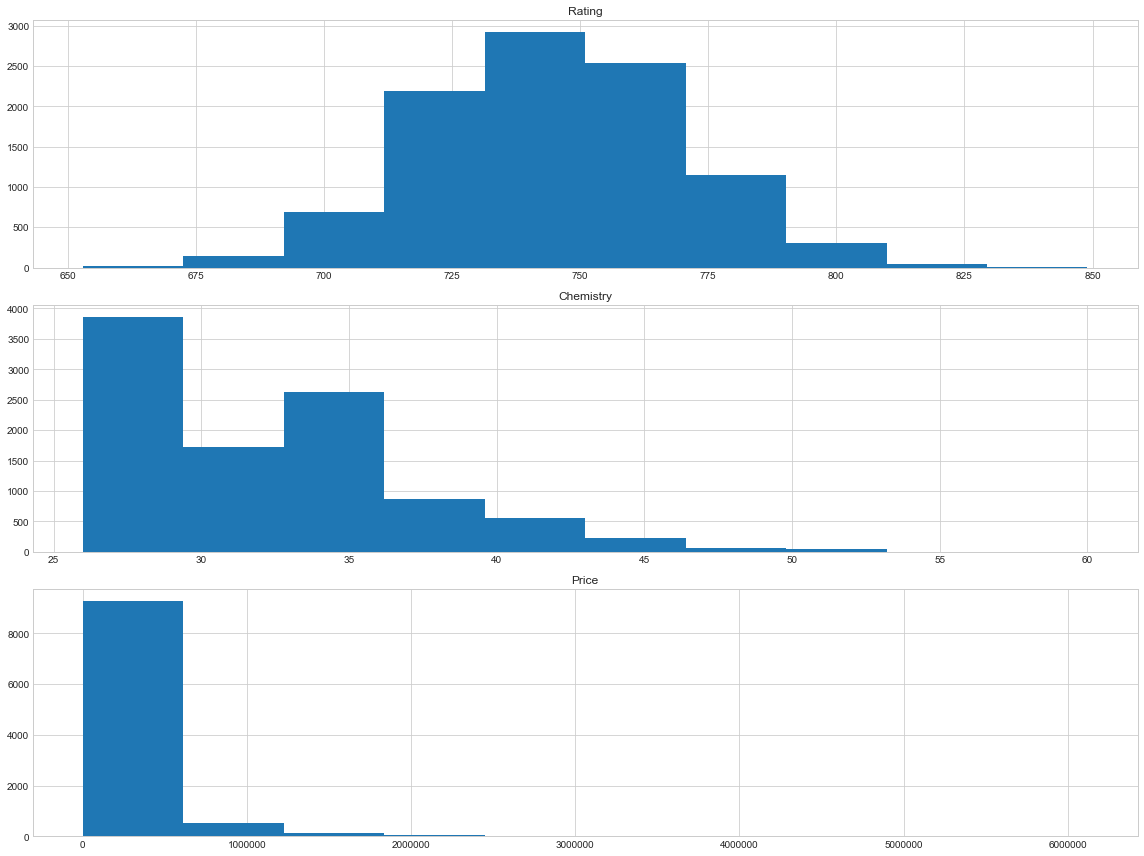

In [38]:
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(3, 1, figsize=(16, 12))

for ax, data, title in zip(axs, [ratings, chemistries, prices], ["Rating", "Chemistry", "Price"]):
    ax.hist(data)
    ax.set_title(label=title)    
    
fig.tight_layout()
plt.show()

In [39]:
rating_mean = np.mean(ratings)
rating_std = np.std(ratings)

chemistry_mean = np.mean(chemistries)
chemistry_std = np.std(chemistries)

price_mean = np.mean(prices)
price_std = np.std(prices)

In [40]:
print("RATING: mean={0:.2f}, std={1:.2f}".format(rating_mean, rating_std))
print("CHEMISTRY: mean={0:.2f}, std={1:.2f}".format(chemistry_mean, chemistry_std))
print("PRICE: mean={0:.2f}, std={1:.2f}".format(price_mean, price_std))

RATING: mean=744.69, std=24.84
CHEMISTRY: mean=32.45, std=4.73
PRICE: mean=133813.39, std=367373.38


In [41]:
def loss(formation):
    players = [s.player for s in formation.slots.values()]
    rating = (formation.get_rating() - rating_mean) / rating_std # normalised rating.
    chemistry = (formation.get_chemistry() - chemistry_mean) / chemistry_std # normalised chemistry.
    price = -(formation.get_price() - price_mean) / price_std # negative, normalised price.
    return RATING_WEIGHT * rating + CHEMISTRY_WEIGHT * chemistry + PRICE_WEIGHT * price

In [43]:
fitness_log = []
rating_log = []
chemistry_log = []
price_log = []
champion_log = []

N_INDIVIDUALS = 100
N_GENERATIONS = 1000

REPLACE_MUTATION_PROBABILITY = 0.75
SWAP_MUTATION_PROBABILITY = 0.2
SWITCH_MUTATION_PROBABILITY = 0.05
CROSSOVER_PROBABILITY = 0.05

RATING_WEIGHT = 1
CHEMISTRY_WEIGHT = 0.25
PRICE_WEIGHT = 1

champion = None
population = [initialise_individual(formation) for _ in range(N_INDIVIDUALS)]
for individual in population:
    individual.evaluate(formation)

for i in range(N_GENERATIONS):
    population = select_individuals(population)
    for j in range(int(len(population)/2)):
        individuals = population[2*j:2*j+2]
        if np.random.uniform() < CROSSOVER_PROBABILITY:
            crossover_individuals(*individuals, formation)
        for individual in individuals:
            mutate_individual(individual, REPLACE_MUTATION_PROBABILITY, SWAP_MUTATION_PROBABILITY, SWITCH_MUTATION_PROBABILITY)
            individual.evaluate(formation)
    challenger = population[np.argmax(population)]
    if not champion or challenger > champion:
        champion = challenger
        champion_log.append(champion)
    champion.fill(formation)
    fitness_log.append(champion.fitness)
    rating_log.append(formation.get_rating())
    chemistry_log.append(formation.get_chemistry())
    price_log.append(formation.get_price())
    if i % 100 == 0:
        print("TURN {}".format(i))
        print("PLAYERS:")
        for k, v in champion.player_map.items():
            print("\t{}: {}".format(k, v))
        print("FITNESS: {0:.2f}".format(champion.fitness))
        print("RATING: {}".format(formation.get_rating()))
        print("CHEMISTRY: {}".format(formation.get_chemistry()))
        print("PRICE: {}".format(int(formation.get_price())))
        print("")
        
print("FINAL CHAMPION")
print("PLAYERS:")
for k, v in champion.player_map.items():
    print("\t{}: {}".format(k, v))
print("FITNESS: {0:.2f}".format(champion.fitness))
print("RATING: {}".format(formation.get_rating()))
print("CHEMISTRY: {}".format(formation.get_chemistry()))


print("PRICE: {}".format(int(formation.get_price())))

TURN 0
PLAYERS:
	GK: Player(id=5279, name=Randolph, overall=71, position=GK, price=2100, nationality=Republic of Ireland, league=EFL Championship, club=Middlesbrough)
	LWB: Player(id=13899, name=Pité, overall=65, position=LB, price=400, nationality=Portugal, league=Liga NOS, club=Tondela)
	CB1: Player(id=7007, name=Nuno Tomás, overall=68, position=CB, price=800, nationality=Portugal, league=Liga NOS, club=CF Os Belenenses)
	CB2: Player(id=5433, name=Laifis, overall=74, position=CB, price=500, nationality=Cyprus, league=Belgium Pro League, club=Standard de Liège)
	CB3: Player(id=16544, name=Stearman, overall=69, position=CB, price=700, nationality=England, league=EFL Championship, club=Sheffield United)
	RWB: Player(id=2274, name=Diogo Figueiras, overall=74, position=RB, price=2100, nationality=Portugal, league=Liga NOS, club=SC Braga)
	CM1: Player(id=1160, name=Fejsa, overall=83, position=CDM, price=9700, nationality=Serbia, league=Liga NOS, club=SL Benfica)
	CM2: Player(id=9671, name=

In [45]:
len(champion_log)

33

In [48]:
with open("../input/champion_log.p", "wb") as f:
    pickle.dump(champion_log, f)

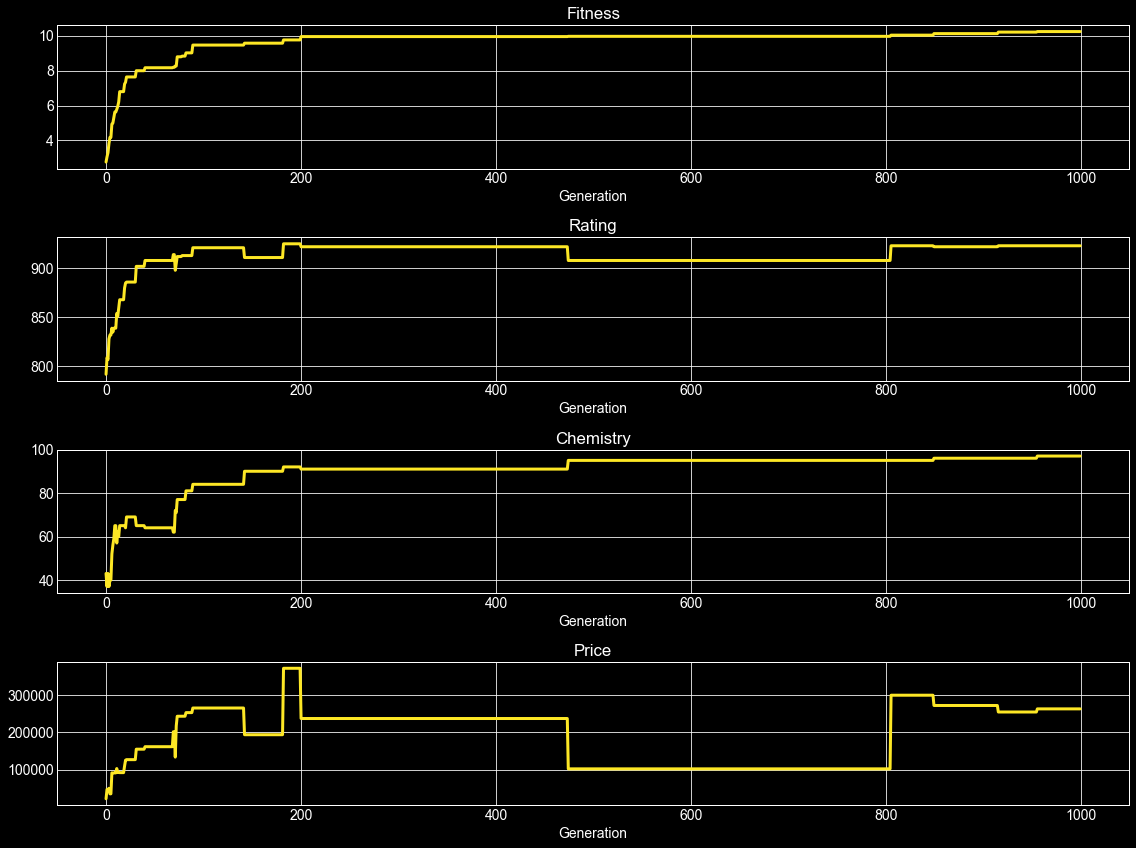

In [65]:
x = np.arange(0, N_GENERATIONS)
fig, axs = plt.subplots(4, 1, figsize=(16, 12))

for ax, data, title in zip(axs, [fitness_log, rating_log, chemistry_log, price_log], ["Fitness", "Rating", "Chemistry", "Price"]):
    ax.plot(x, data, linewidth=3, color=cmap(1.))
    ax.set_title(label=title)
    ax.set_xlabel("Generation")    
    
fig.tight_layout()

plt.savefig("../images/fitness_curve.png", dpi=120)